### Stage 1: Data Ingestion

- [ ] Define Configuration for Interacting with Kaggle Public API
- [ ] Download Kaggle Dataset using Kaggle Credentials and Save Data to `data` directory
- [ ] Create a Pipeline that automates data ingestion for any publically available Kaggle Dataset


#### Configuration

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /mnt/e/Research/dvc/deepgloberoadextraction


In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class DataIngestionConfig:
    # Kaggle Credentials from secrets.yaml
    username: str
    token: str
    # config.yaml
    download_dir: Path
    dataset_id: str

from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, SECRETS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml, create_directories, show_config

class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, secrets_filepath = SECRETS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.secrets = read_yaml(secrets_filepath)
        create_directories([self.config.data_ingestion.download_dir])
    
    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        secrets = self.secrets.kaggle
        cfg = DataIngestionConfig(
            download_dir=Path(config.download_dir),
            dataset_id=config.dataset_id,
            username=secrets.username,
            token=secrets.token
        )
        return cfg
    
cfg = ConfigurationManager().get_data_ingestion_config()

show_config(cfg)

[2024-06-17 12:50:02,111: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-17 12:50:02,119: INFO: common: yaml file: secrets.yaml loaded successfully]
[2024-06-17 12:50:02,121: INFO: common: created directory at: data]
Configuration:

username: adityasharma47
token: dcc850f67e063a3c25586bc8e81edefe
download_dir: data
dataset_id: balraj98/deepglobe-road-extraction-dataset


#### Components

In [3]:
import os
import subprocess
import json
from DeepGlobeRoadExtraction import logger

class DataIngestionComponents:
    def __init__(self, config: DataIngestionConfig) -> None:
        self.config = config

    def initialise_kaggle(self):
        logger.info(f'---------- Initialising Kaggle Account ----------')
        # Set Path for Kaggle Configration File
        KAGGLE_CONFIG_DIR = os.path.join(os.path.expandvars('$HOME'), '.kaggle')
        KAGGLE_CONFIG_FILE = os.path.join(KAGGLE_CONFIG_DIR, 'kaggle.json')
        
        # Check if kaggle.json already exists and is not empty
        if os.path.exists(KAGGLE_CONFIG_FILE) and os.path.getsize(KAGGLE_CONFIG_FILE) > 0:
            logger.warning(f'---> Kaggle Account Credentials Found ==> {KAGGLE_CONFIG_FILE}. Remove this file and re-initialse if API token is invalid or has expired.')
            return
        
        # Otherwise create .kaggle directory
        os.makedirs(KAGGLE_CONFIG_DIR, exist_ok=True)
        
        try:
            username = self.config.username
            token = self.config.token
            api_dict = {'username': username, 'key': token}
            
            # Create a kaggle.json file inside .kaggle folder and add your credentials
            with open(KAGGLE_CONFIG_FILE, "w", encoding="utf-8") as f:
                json.dump(api_dict, f)
            
            # Change File Permissions
            cmd = f"chmod 600 {KAGGLE_CONFIG_FILE}"
            output = subprocess.check_output(cmd.split(" "))
            output = output.decode(encoding="utf-8")
        except Exception as e:
            logger.error('Failed to Initialise Kaggle Account!')
            raise e
        
    # Download Kaggle Dataset
    def download_dataset(self):
        from kaggle.api.kaggle_api_extended import KaggleApi
        logger.info(f'---------- Downloading Kaggle Dataset: {self.config.dataset_id} ----------')
        try:
            api = KaggleApi()
            api.authenticate()
            api.dataset_download_files(
                dataset=self.config.dataset_id,
                path=self.config.download_dir,
                unzip=True,
                force=False,
                quiet=True
            )
            logger.info('---> Download Complete!')
        except Exception as e:
            logger.error('Kaggle dataset download failed!')
            raise e

#### Pipeline

In [4]:
class DataIngestionPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        config = ConfigurationManager().get_data_ingestion_config()
        pipeline = DataIngestionComponents(config=config)
        pipeline.initialise_kaggle()
        pipeline.download_dataset()
        
DataIngestionPipeline().main()

[2024-06-17 12:38:43,329: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-17 12:38:43,332: INFO: common: yaml file: secrets.yaml loaded successfully]
[2024-06-17 12:38:43,333: INFO: common: created directory at: data]
[2024-06-17 12:38:43,333: INFO: 4097356871: ---------- Initialising Kaggle Account ----------]
[2024-06-17 12:38:43,338: WARNING: 4097356871: ---> Kaggle Account Credentials Found ==> /home/asharma271/.kaggle/kaggle.json. Remove this file and re-initialse if API token is invalid or has expired.]
[2024-06-17 12:38:44,703: INFO: 4097356871: ---------- Downloading Kaggle Dataset: balraj98/deepglobe-road-extraction-dataset ----------]
Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-road-extraction-dataset
[2024-06-17 12:46:38,191: INFO: 4097356871: ---> Download Complete!]


### Stage 2: Data Preparation
- [ ] Read `metadata.csv` 
- [ ] Split training images into training and validation split using random state from `params.yaml`
- [ ] Export updated metadata with split group column as a new metadata.csv file called `metadataV2.csv` and save to data directory

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /Users/geovicco/Coding/Projects/deepgloberoadextraction


#### Configuration

In [3]:
from dataclasses import dataclass
from pathlib import Path
from typing import List

@dataclass(frozen=True)
class DataPreparationConfig:
    # config.yaml
    data_directory: Path
    metadata_csv: Path
    out_metadata_csv: Path
    # params.yaml
    random_state: int
    train_val_split: List[float]
    
from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml, show_config

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_data_preparation_config(self) -> DataPreparationConfig:
        config = self.config.data_preparation
        params = self.params
        cfg = DataPreparationConfig(
            data_directory=Path(config.data_dir),
            metadata_csv=Path(config.metadata_csv),
            random_state=params.random_state,
            train_val_split=params.train_val_split,
            out_metadata_csv=Path(config.out_metadata_csv)
        )
        return cfg
    
cfg = ConfigurationManager().get_data_preparation_config()
show_config(cfg)

[2024-06-17 12:50:26,904: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-17 12:50:26,907: INFO: common: yaml file: params.yaml loaded successfully]
Configuration:

data_directory: data
metadata_csv: data/metadata.csv
out_metadata_csv: data/metadataV2.csv
random_state: 26
train_val_split: [0.7, 0.2, 0.1]


#### Components

In [4]:
from DeepGlobeRoadExtraction import logger
import pandas as pd
from sklearn.model_selection import train_test_split

class DataPreparationComponents:
    def __init__(self, config: DataPreparationConfig) -> None:
        self.config = config
        
    def load_metadata(self):
        logger.info(f'------------- Loading Metadata -------------')
        metadata_df = pd.read_csv(self.config.metadata_csv) # Read Metadata
        metadata_df = metadata_df[metadata_df['split']=='train'] # Filter all rows that have 'train' in the 'split' column
        metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']] # Keep only 'image_id', 'sat_image_path' and 'mask_path' columns
        metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(self.config.data_directory, img_pth)) # Add data_directory to sat_image_path
        metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(self.config.data_directory, img_pth)) # Add data_directory to mask_path
        self.metadata = metadata_df 
    
    def split_dataset(self):
        logger.info(f'------------- Splitting Training Dataset into Train and Validation -------------')
        metadata_df = self.metadata
        # Shuffle DataFrame
        metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
        # Perform split for train / val
        train_df, valid_df = train_test_split(metadata_df, train_size=self.config.train_val_split[0], random_state=self.config.random_state)
        valid_df, test_df = train_test_split(valid_df, train_size=self.config.train_val_split[1]/(self.config.train_val_split[1]+self.config.train_val_split[2]), random_state=self.config.random_state)
        train_df['group'] = 'train'
        valid_df['group'] = 'val'
        test_df['group'] = 'test'
        # Concatenate DataFrames
        self.metadata = pd.concat([train_df, valid_df, test_df])
        # Export Metadata
        self.metadata.to_csv(self.config.out_metadata_csv, index=False)
        del train_df, valid_df, test_df, metadata_df

#### Pipeline

In [5]:
class DataPreparationPipeline:
    def __init__(self) -> None:
        pass
    
    def main(self):
        config = ConfigurationManager().get_data_preparation_config()
        pipeline = DataPreparationComponents(config=config)
        pipeline.load_metadata()
        pipeline.split_dataset()
        
DataPreparationPipeline().main()

[2024-06-17 12:51:00,006: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-17 12:51:00,010: INFO: common: yaml file: params.yaml loaded successfully]
[2024-06-17 12:51:00,011: INFO: 3406445105: ------------- Loading Metadata -------------]
[2024-06-17 12:51:00,069: INFO: 3406445105: ------------- Splitting Training Dataset into Train and Validation -------------]


### Stage 3: Model Training and Evaluation

- [ ] Read `data/metadataV2.csv' 
- [ ] Create PyTorch Lightning Data Module
  - Input Arguments: `metadataV2.csv`, `batch_size`, `augmentations`, `prefetch_factor`, `num_workers`, and `resize_dimensions`
- [ ] Initialise Model
  - [ ] Load Weights [Optional]
  - [ ] Define Callbacks 
- [ ] Train Model
- [ ] Evaluate Model
- [ ] Save Model as ONNX, .pth, and State Dict

In [1]:
import os
os.chdir('../')
print(f'Current Working Directory: {os.getcwd()}')

Current Working Directory: /mnt/e/Research/dvc/deepgloberoadextraction


In [2]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
    # config.yaml
    models_dir: Path
    metadata_csv: Path
    logs_dir: Path
    # params.yaml
    architecture: str
    encoder: str
    encoder_weights: str
    n_classes: int
    n_channels: int
    epochs: int
    lr: float
    batch_size: int
    device: str
    num_workers: int
    prefetch_factor: int
    resize_dimension: int
    checkpoint_path: Path
    encoder: str
    optimizer: str
    loss: str
    apply_preprocessing: bool
    tune_lr: bool
    
from DeepGlobeRoadExtraction import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from DeepGlobeRoadExtraction.utils.common import read_yaml, show_config

class ConfigurationManager:
    def __init__(self, config_filepath=CONFIG_FILE_PATH, params_filepath=PARAMS_FILE_PATH) -> None:
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
    
    def get_training_config(self) -> TrainingConfig:
        config = self.config.training
        params = self.params
        cfg = TrainingConfig(
            models_dir=Path(config.models_dir),
            metadata_csv=Path(config.metadata_csv),
            logs_dir=Path(config.logs_dir),
            architecture=params.architecture,
            encoder=params.encoder,
            encoder_weights=params.encoder_weights,
            n_classes=params.n_classes,
            n_channels=params.n_channels,
            epochs=params.epochs,
            lr=params.lr,
            batch_size=params.batch_size,
            device=params.device,
            num_workers=params.num_workers,
            prefetch_factor=params.prefetch_factor,
            resize_dimension=params.resize_dimension,
            checkpoint_path=None if params.checkpoint_path == 'None' else Path(params.checkpoint_path),
            optimizer=params.optimizer,
            loss=params.loss,
            apply_preprocessing=params.apply_preprocessing,
            tune_lr=params.tune_lr
        )
        return cfg
    
cfg = ConfigurationManager().get_training_config()

show_config(cfg)

[2024-06-17 21:30:08,771: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-17 21:30:08,780: INFO: common: yaml file: params.yaml loaded successfully]
Configuration:

models_dir: models
metadata_csv: data/metadataV2.csv
logs_dir: logs
architecture: Unet
encoder: resnet101
encoder_weights: imagenet
n_classes: 1
n_channels: 3
epochs: 25
lr: 1e-05
batch_size: 12
device: cuda
num_workers: 24
prefetch_factor: 12
resize_dimension: 512
checkpoint_path: models/checkpoints/epoch=12-val_f1=0.57.ckpt
optimizer: adamax
loss: JaccardLoss
apply_preprocessing: False
tune_lr: False


In [3]:
from DeepGlobeRoadExtraction import logger
from DeepGlobeRoadExtraction.utils.dataloader import RoadsDataModule, get_training_augmentation, get_preprocessing, get_preprocessing_function
from DeepGlobeRoadExtraction.utils.model import SegmentationModel
import warnings; warnings.filterwarnings("ignore")
import torch
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import random
torch.set_float32_matmul_precision('medium')

class TrainingComponents:
    def __init__(self, config: TrainingConfig) -> None:
        self.config = config
        
    def create_dataloaders(self):
        logger.info(f'------------- Creating Dataloaders -------------')
        if self.config.apply_preprocessing:
            logger.info('------------->>> Applying Preprocessing <<<-------------')
            self.dm = RoadsDataModule(
                metadata_csv=self.config.metadata_csv,
                augmentation=get_training_augmentation(),
                preprocessing=get_preprocessing(get_preprocessing_function(self.config.encoder, self.config.encoder_weights)),
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                resize_dimensions=self.config.resize_dimension
            )
        else:
            logger.info('------------->>> Skipping Applying Preprocessing <<<-------------')
            self.dm = RoadsDataModule(
                metadata_csv=self.config.metadata_csv,
                augmentation=get_training_augmentation(),
                preprocessing=None,
                batch_size=self.config.batch_size,
                num_workers=self.config.num_workers,
                resize_dimensions=self.config.resize_dimension
            )
            
        # Plot sample from the training dataset
    @staticmethod
    def plot_train_batch(dm, n_samples=4, randomised=True):
        dm.setup('fit')
        # Get the train dataloader
        dataloader = dm.train_dataloader()

        if randomised:
            # Randomly select a batch of data
            x, y = random.choice(list(dataloader))
        else:
            # Select from first batch of data
            x, y = next(iter(dataloader))

        # Plot the results
        fig, axs = plt.subplots(n_samples, 2, figsize=(10, n_samples*5))
        for i in range(n_samples):
            # Plot the image
            image = x[i].cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
            # Get Vmin and Vmax as 2nd and 98th percentile
            vmin = np.percentile(image, 2)
            vmax = np.percentile(image, 98)
            axs[i, 0].imshow(image, vmin=vmin, vmax=vmax)
            axs[i, 0].axis('off')
            if i == 0:
                axs[i, 0].set_title('Image')
            
            # Plot the ground truth mask
            ground_truth_mask = y[i].cpu().numpy().squeeze()  # (1, H, W) -> (H, W)
            axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
            axs[i, 1].axis('off')
            if i == 0:
                axs[i, 1].set_title('Ground Truth Mask')

        plt.tight_layout()
        plt.show()
    
    def initialise_model(self):
        logger.info(f'------------- Inistialising Model: Architecture: {self.config.architecture} | Encoder: {self.config.encoder} | Encoder Weights: {self.config.encoder_weights} -------------')
        self.model = SegmentationModel(
            architecture=self.config.architecture,
            n_channels=self.config.n_channels,
            n_classes=self.config.n_classes,
            lr=self.config.lr,
            encoder=self.config.encoder,
            encoder_weights=self.config.encoder_weights,
            loss=self.config.loss,
            optimizer=self.config.optimizer,
        )
    
    def load_checkpoint(self):
        if self.config.checkpoint_path is not None and os.path.exists(self.config.checkpoint_path):
            logger.info('------------- Loading Checkpoint -------------')
            logger.info(f'Loading checkpoint from {self.config.checkpoint_path}')
            try:
                self.model = SegmentationModel.load_from_checkpoint(self.config.checkpoint_path, hparams_file='params.yaml')
                logger.info('Checkpoint loaded successfully')
            except Exception as e:
                logger.error(f'Failed to load checkpoint: {e}')
        else:
            logger.error('Checkpoint not found.')
    
    def create_callbacks(self):
        logger.info('------------- Creating Callbacks -------------')
        ### Define Checkpoints for Early Stopping, Tensorboard Summary Writer, and Best Checkpoint Saving
        from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
        from pytorch_lightning.loggers import TensorBoardLogger

        # Early stopping callback
        self.early_stopping = EarlyStopping(
            monitor='val_loss',  # Metric to monitor
            patience=10,          # Number of epochs with no improvement after which training will be stopped
            verbose=True,
            mode='min'           # Mode can be 'min' for minimizing the monitored metric or 'max' for maximizing it
        )

        # Model checkpoint callback
        self.checkpoint_callback = ModelCheckpoint(
            monitor='val_f1',   # Metric to monitor
            filename='{epoch:02d}-{val_f1:.2f}',  # Filename format
            save_top_k=1,         # Save the top k models
            mode='max',           # Mode can be 'min' or 'max'
            verbose=True,
            dirpath=self.config.logs_dir.joinpath(f'{self.config.architecture}_{self.config.encoder}_{self.config.encoder_weights}/checkpoints')
        )

        # TensorBoard logger
        self.tensorboard_logger = TensorBoardLogger(
            save_dir=self.config.logs_dir,     # Directory to save the logs
            name=f"{self.config.architecture}_{self.config.encoder}_{self.config.encoder_weights}"       # Experiment name
        )

        from pytorch_lightning.callbacks import LearningRateMonitor
        # Learning rate monitor
        self.lr_monitor = LearningRateMonitor(logging_interval='epoch')
        
    def tune_lr(self):
        if self.config.tune_lr:
            from pytorch_lightning.tuner.tuning import Tuner
            logger.info('------------- Tunning Learning Rate -------------')
            # Define a separate trainer for hyperparameter tuning
            self.tuning_trainer = pl.Trainer(
                accelerator=self.config.device,
                precision="16-mixed",
                logger=self.tensorboard_logger,
                callbacks=None,
                max_epochs=5  # Set this to a low number for faster tuning
            )

            self.dm.setup('fit')

            # Hyperparameter tuning
            self.tuner = Tuner(self.tuning_trainer)
            self.new_lr = self.tuner.lr_find(self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader()).suggestion()
            logger.info(f'Suggested learning rate: {self.new_lr}')
        else:
            logger.info('------------- Skipping Tunning Learning Rate -------------')
            
        
    def create_trainer(self):
        logger.info(f'------------- Training Model: {self.config.architecture} with {self.config.encoder} Encoder using {self.config.encoder_weights} Weights -------------')

        self.trainer = pl.Trainer(
            accelerator=self.config.device,
            max_epochs=self.config.epochs,
            precision="16-mixed",
            logger= self.tensorboard_logger if hasattr(self, 'tensorboard_logger') else None,
            callbacks=[self.early_stopping, self.checkpoint_callback, self.lr_monitor],
            enable_progress_bar=True,
            fast_dev_run=False
        )
    
    def train(self):
        logger.info('------------- Training Started -------------')
        self.dm.setup('fit')
        self.trainer.fit(model=self.model, train_dataloaders=self.dm.train_dataloader(), val_dataloaders=self.dm.val_dataloader())
        logger.info('------------- Training Completed -------------')

In [4]:
# class TrainingPipeline:
#     def __init__(self) -> None:
#         pass
    
#     def main(self):
#         config = ConfigurationManager().get_training_config()
#         pipeline = TrainingComponents(config=config)
#         pipeline.create_dataloaders()
#         pipeline.initialise_model()
#         pipeline.load_checkpoint()
#         pipeline.create_callbacks()
#         pipeline.tune_lr()
#         pipeline.create_trainer()
#         pipeline.train()
        
# TrainingPipeline().main()

In [5]:
config = ConfigurationManager().get_training_config()
pipeline = TrainingComponents(config=config)
pipeline.create_dataloaders()
pipeline.initialise_model()
pipeline.load_checkpoint()

[2024-06-17 21:30:48,047: INFO: common: yaml file: config.yaml loaded successfully]
[2024-06-17 21:30:48,050: INFO: common: yaml file: params.yaml loaded successfully]
[2024-06-17 21:30:48,050: INFO: 1070428383: ------------- Creating Dataloaders -------------]
[2024-06-17 21:30:48,051: INFO: 1070428383: ------------->>> Skipping Applying Preprocessing <<<-------------]
[2024-06-17 21:30:48,062: INFO: 1070428383: ------------- Inistialising Model: Architecture: Unet | Encoder: resnet101 | Encoder Weights: imagenet -------------]
[2024-06-17 21:30:48,624: INFO: 1070428383: ------------- Loading Checkpoint -------------]
[2024-06-17 21:30:48,625: INFO: 1070428383: Loading checkpoint from models/checkpoints/epoch=12-val_f1=0.57.ckpt]
[2024-06-17 21:30:53,563: INFO: 1070428383: Checkpoint loaded successfully]


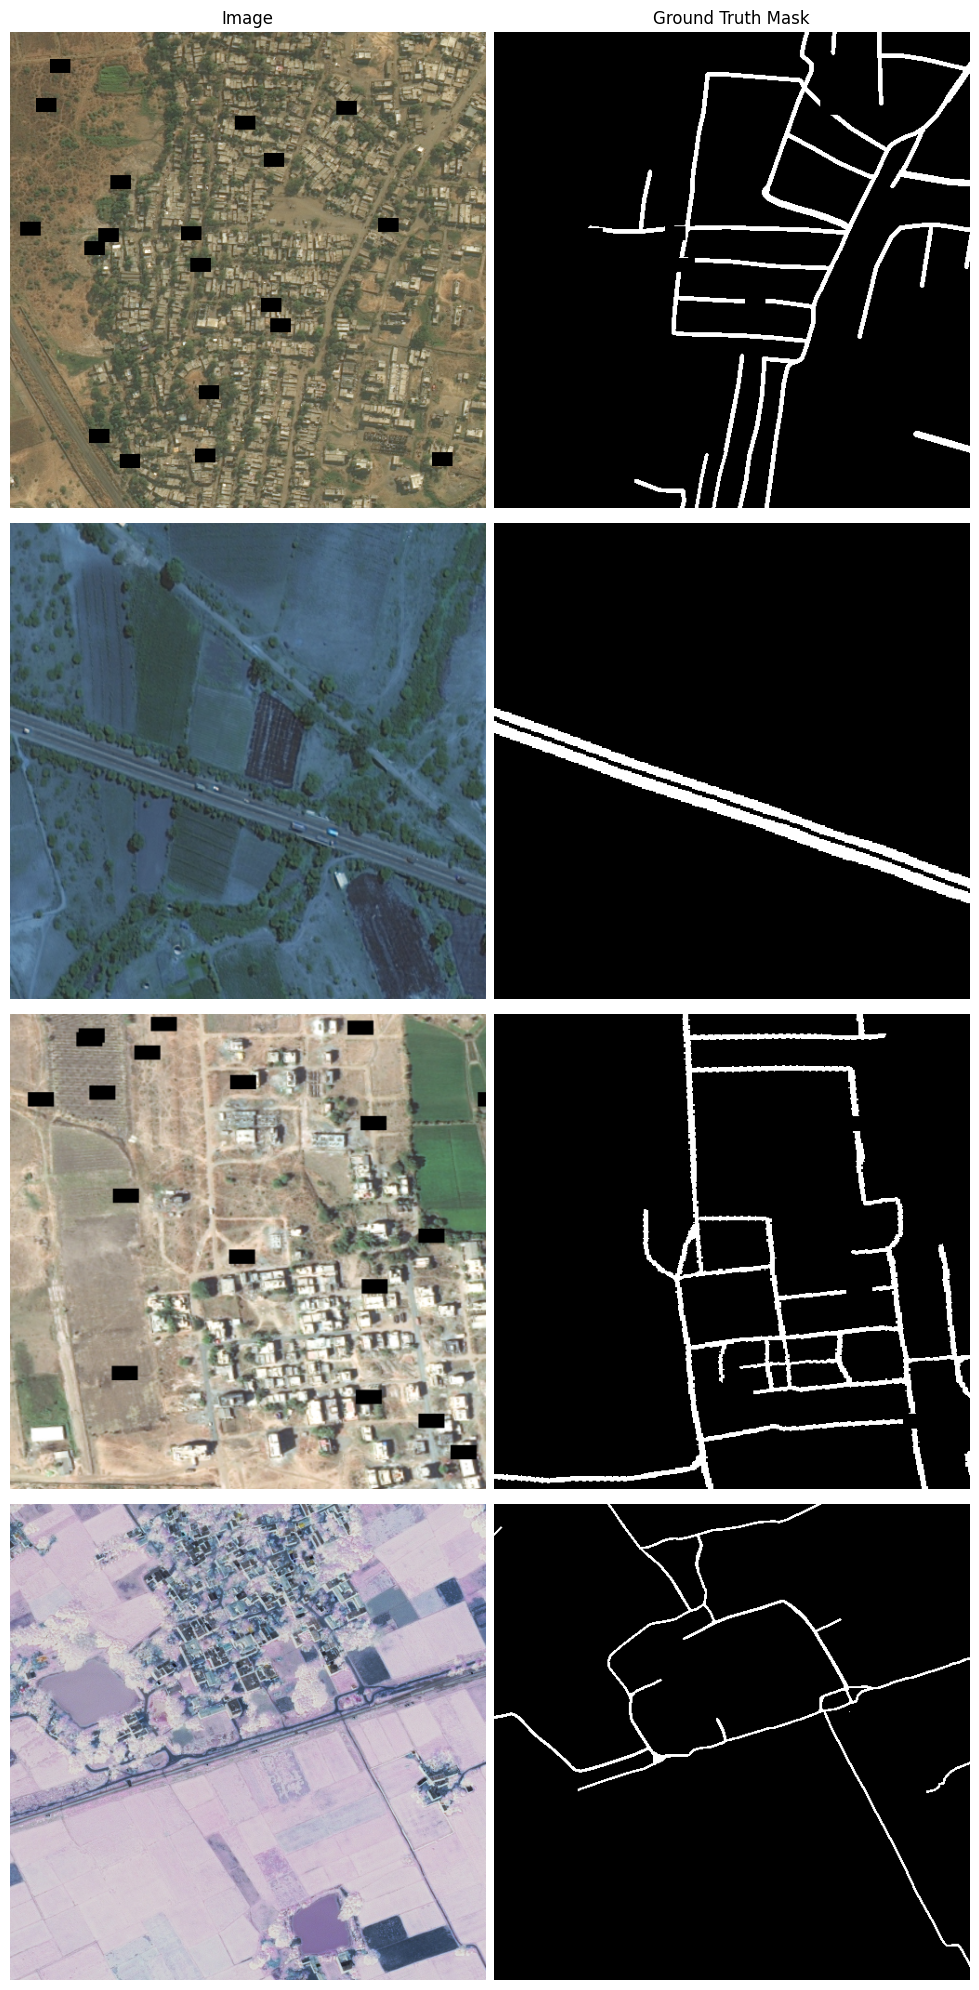

In [7]:
pipeline.plot_train_batch(dm=pipeline.dm, randomised=False)

In [8]:
pipeline.create_callbacks()
pipeline.tune_lr()
pipeline.create_trainer()
pipeline.train()

Validation: |          | 0/? [00:00<?, ?it/s]

[2024-06-17 22:01:36,136: INFO: early_stopping: Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.527]
[2024-06-17 22:01:36,138: INFO: rank_zero: Epoch 10, global step 3993: 'val_f1' was not in top 1]


Validation: |          | 0/? [00:00<?, ?it/s]

[2024-06-17 22:04:12,039: INFO: early_stopping: Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.515]
[2024-06-17 22:04:12,041: INFO: rank_zero: Epoch 11, global step 4356: 'val_f1' reached 0.71754 (best 0.71754), saving model to '/mnt/e/Research/dvc/deepgloberoadextraction/logs/Unet_resnet101_imagenet/checkpoints/epoch=11-val_f1=0.72.ckpt' as top 1]


Validation: |          | 0/? [00:00<?, ?it/s]

[2024-06-17 22:06:51,338: INFO: early_stopping: Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.510]
[2024-06-17 22:06:51,340: INFO: rank_zero: Epoch 12, global step 4719: 'val_f1' was not in top 1]
[2024-06-17 22:08:10,810: INFO: 1070428383: ------------- Training Completed -------------]


In [12]:
# Evaluation

# Setup and test
pipeline.dm.setup('test')
try:
    test_results = pipeline.trainer.test(dataloaders=pipeline.dm.test_dataloader())
    
    # Extract relevant metrics from test_results
    # Assuming test_results is a list of dictionaries and contains y_true and y_pred
    metrics = test_results[0] if test_results else {}

    # Save metrics to a file
    # save_json(pipeline.config.metrics_filepath, metrics)  # Save the metrics to a file
    
except Exception as e:
    print(f"An error occurred: {e}")

[2024-06-17 22:10:48,516: INFO: rank_zero: Restoring states from the checkpoint path at /mnt/e/Research/dvc/deepgloberoadextraction/logs/Unet_resnet101_imagenet/checkpoints/epoch=11-val_f1=0.72.ckpt]
[2024-06-17 22:10:50,848: INFO: cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]]
[2024-06-17 22:10:50,862: INFO: rank_zero: Loaded model weights from the checkpoint at /mnt/e/Research/dvc/deepgloberoadextraction/logs/Unet_resnet101_imagenet/checkpoints/epoch=11-val_f1=0.72.ckpt]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.7180108428001404
         test_f2            0.7371311187744141
        test_iou            0.5610550045967102
        test_loss           0.5135014653205872
     test_precision         0.6906203627586365
       test_recall          0.7406827807426453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

pipeline.dm.setup('test')

# Get the test dataloader
test_dataloader = pipeline.dm.test_dataloader()
test_dataloader_list = list(test_dataloader)

# Randomly select a batch of data
x, y = random.choice(test_dataloader_list)

# Put the model in evaluation mode
pipeline.model.eval()

# Disable gradients for this step
with torch.no_grad():
    # Pass the data through the model
    y_hat = pipeline.model(x)#.to(pipeline.config.device)).cpu()

# Plot the results
fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Increase the number of columns to 3
for i in range(4):
    # Plot the image
    image = np.transpose(x[i][:3, :, :]).squeeze()
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = np.transpose(y[i]).squeeze()
    axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Ground Truth Mask')

    # Plot the predicted mask - with and without thresholding
    predicted_mask = torch.sigmoid(np.transpose(y_hat[i])).squeeze()
    axs[i, 2].imshow(predicted_mask, cmap='RdYlGn')
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 2].set_title('Predicted Mask (Raw)')

    axs[i, 3].imshow(predicted_mask > 0.5, cmap='binary_r')
    axs[i, 3].axis('off')
    if i == 0:
        axs[i, 3].set_title('Predicted Mask (Thresholded)')
    
# Remove empty subplots
for j in range(4, 4):
    for i in range(4):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### Model Training

### Stage 4: Evaluation

Load Dataloader
- [ ] Initialise and Load Model Checkpoint
- [ ] Evalute on Test Dataloader
- [ ]

In [12]:
from DeepGlobeRoadExtraction.utils.common import save_json

# Setup and test
dm.setup('test')
try:
    test_results = trainer.test(dataloaders=dm.test_dataloader())
    
    # Extract relevant metrics from test_results
    # Assuming test_results is a list of dictionaries and contains y_true and y_pred
    metrics = test_results[0] if test_results else {}

    # Save metrics to a file
    save_json(pipeline.config.metrics_filepath, metrics)  # Save the metrics to a file
    
except Exception as e:
    print(f"An error occurred: {e}")

[2024-06-09 22:43:44,590: INFO: rank_zero: Restoring states from the checkpoint path at /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction/models/checkpoints/epoch=07-val_f1=0.54.ckpt]
[2024-06-09 22:43:45,593: INFO: cuda: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]]
[2024-06-09 22:43:45,915: INFO: rank_zero: Loaded model weights from the checkpoint at /mnt/e/Research/deepgloberoadextraction/deepgloberoadextraction/models/checkpoints/epoch=07-val_f1=0.54.ckpt]
Testing DataLoader 0: 100%|██████████| 78/78 [02:48<00:00,  0.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.5342864990234375
        test_iou            0.3662492036819458
        test_loss           0.6334958076477051
     test_precision        

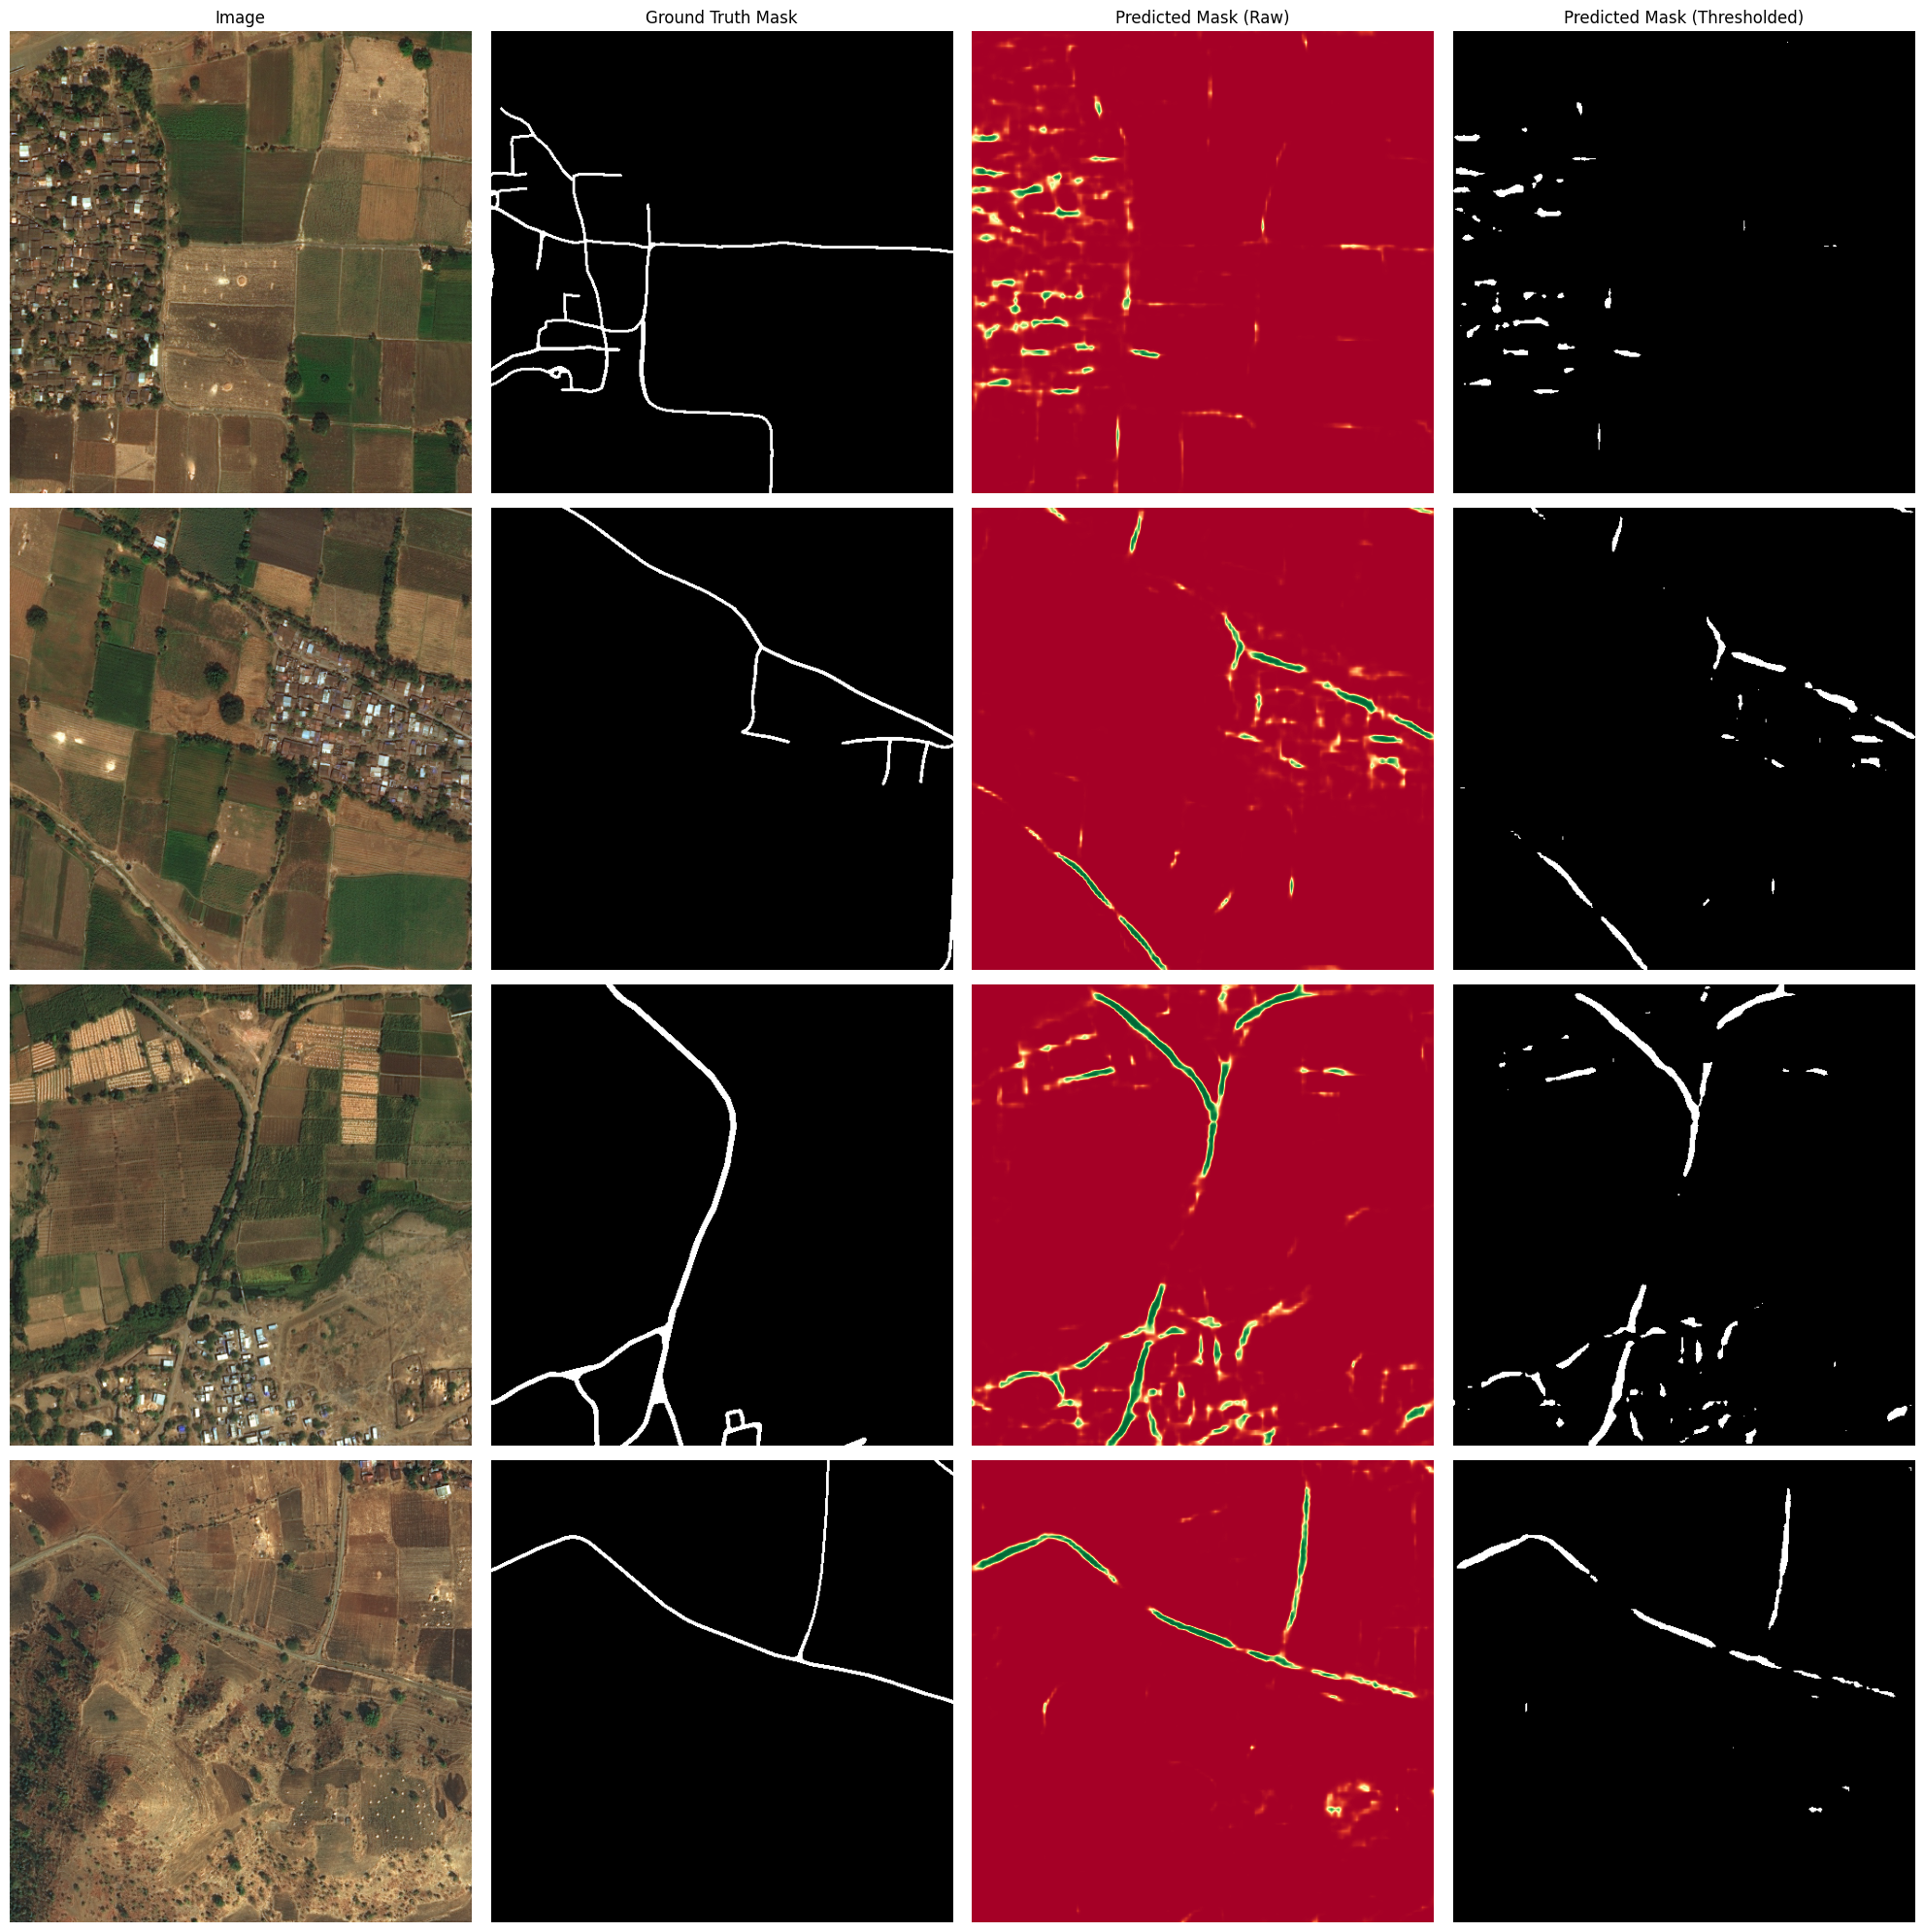

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

dm.setup('test')

# Get the test dataloader
test_dataloader = dm.test_dataloader()

# Randomly select a batch of data
x, y = next(iter(test_dataloader))

# Put the model in evaluation mode
model.eval()

# Disable gradients for this step
with torch.no_grad():
    # Pass the data through the model
    y_hat = model(x)

# Plot the results
fig, axs = plt.subplots(4, 4, figsize=(20, 20))  # Increase the number of columns to 3
for i in range(4):
    # Plot the image
    image = np.transpose(x[i][:3, :, :]).squeeze()
    axs[i, 0].imshow(image)
    axs[i, 0].axis('off')
    if i == 0:
        axs[i, 0].set_title('Image')
    
    # Plot the ground truth mask
    ground_truth_mask = np.transpose(y[i]).squeeze()
    axs[i, 1].imshow(ground_truth_mask, cmap='binary_r')
    axs[i, 1].axis('off')
    if i == 0:
        axs[i, 1].set_title('Ground Truth Mask')

    # Plot the predicted mask - with and without thresholding
    predicted_mask = torch.sigmoid(np.transpose(y_hat[i])).squeeze()
    axs[i, 2].imshow(predicted_mask, cmap='RdYlGn')
    axs[i, 2].axis('off')
    if i == 0:
        axs[i, 2].set_title('Predicted Mask (Raw)')

    axs[i, 3].imshow(predicted_mask > 0.5, cmap='binary_r')
    axs[i, 3].axis('off')
    if i == 0:
        axs[i, 3].set_title('Predicted Mask (Thresholded)')
    
# Remove empty subplots
for j in range(4, 4):
    for i in range(4):
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()